# __Residual Netwokr - MXNet__

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu()

## __Getting the dataset__

In [3]:
transform = gluon.data.vision.transforms.ToTensor()

train_mnist = gluon.data.vision.CIFAR10(train = True).transform_first(transform)
test_mnist = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [4]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(3, 32, 32)
9


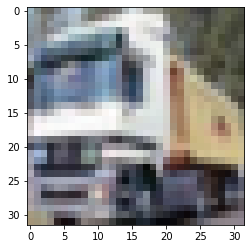

In [5]:
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.show()

## __Defining data loaders__

In [0]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = False)

## __Defining Residual Network Model Architecture__ 

### First we will define single residual connection block

In [0]:
class residualblock(nn.HybridBlock):
    def __init__(self, channels, strides):
        super(residualblock, self).__init__()
        
        self.conv1 = nn.HybridSequential()
        self.conv1.add(nn.Conv2D(channels, kernel_size = 3, padding = 1, strides = strides))
        self.conv1.add(nn.BatchNorm())

        self.conv2 = nn.HybridSequential()
        self.conv2.add(nn.Conv2D(channels, kernel_size = 3, padding = 1))
        self.conv2.add(nn.BatchNorm())

        self.residual = nn.Conv2D(channels, kernel_size = 1, strides = strides)
        # doing network in network convolution(1X1) above for residual connection

        self.activation = nn.Activation('relu')

    def hybrid_forward(self, F, x):
        layer = self.activation(self.conv1(x))
        layer = self.conv2(layer)
        residual = self.residual(x)
        return self.activation(layer + residual)

### Visualizing single block of residual block

/usr/local/lib/python3.6/dist-packages/mxnet/visualization.py:301: RuntimeWarning: There are multiple variables with the same name in your graph, this may result in cyclic graph. Repeated names: relu2_fwd
  warnings.warn(warning_message, RuntimeWarning)


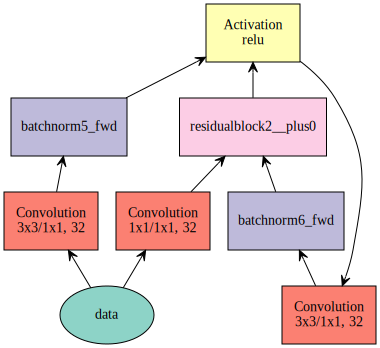

In [16]:
block = residualblock(32, 1)
block.initialize(ctx = ctx)
mx.viz.plot_network(block(mx.sym.var(name = 'data')), node_attrs={"fixedsize":"false"})

## __Defining the whole model__

In [17]:
model = nn.HybridSequential()

model.add(nn.Conv2D(64, kernel_size = 7, strides = 2, padding = 3))
model.add(nn.BatchNorm())
model.add(nn.MaxPool2D(pool_size = 3, strides = 2, padding = 1))

model.add(residualblock(channels = 64, strides = 2))
model.add(residualblock(channels = 64, strides = 2))

model.add(residualblock(channels = 128, strides = 1))
model.add(residualblock(channels = 128, strides = 1))

model.add(residualblock(channels = 256, strides = 1))
model.add(residualblock(channels = 256, strides = 1))

model.add(residualblock(channels = 512, strides = 1))
model.add(residualblock(channels = 512, strides = 1))

model.add(nn.GlobalAvgPool2D())
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Conv2D(None -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (3): residualblock(
    (conv1): HybridSequential(
      (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    )
    (conv2): HybridSequential(
      (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    )
    (residual): Conv2D(None -> 64, kernel_size=(1, 1), stride=(2, 2))
    (activation): Activation(relu)
  )
  (4): residualblock(
    (conv1): HybridSequential(
      (0): Conv2D(None ->

## __Summarizing the model__

In [18]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 32, 32)               0
            Conv2D-1                             (1, 64, 16, 16)            9472
         BatchNorm-2                             (1, 64, 16, 16)             256
         MaxPool2D-3                               (1, 64, 8, 8)               0
            Conv2D-4                               (1, 64, 4, 4)           36928
         BatchNorm-5                               (1, 64, 4, 4)             256
        Activation-6                               (1, 64, 4, 4)               0
            Conv2D-7                               (1, 64, 4, 4)           36928
         BatchNorm-8                               (1, 64, 4, 4)             256
            Conv2D-9                               (1, 64, 4, 4)            4160
       Activation-10        

## __Visializing model architecture__

/usr/local/lib/python3.6/dist-packages/mxnet/visualization.py:301: RuntimeWarning: There are multiple variables with the same name in your graph, this may result in cyclic graph. Repeated names: relu7_fwd,relu9_fwd,relu8_fwd,relu6_fwd,relu5_fwd,relu10_fwd,relu3_fwd,relu4_fwd
  warnings.warn(warning_message, RuntimeWarning)


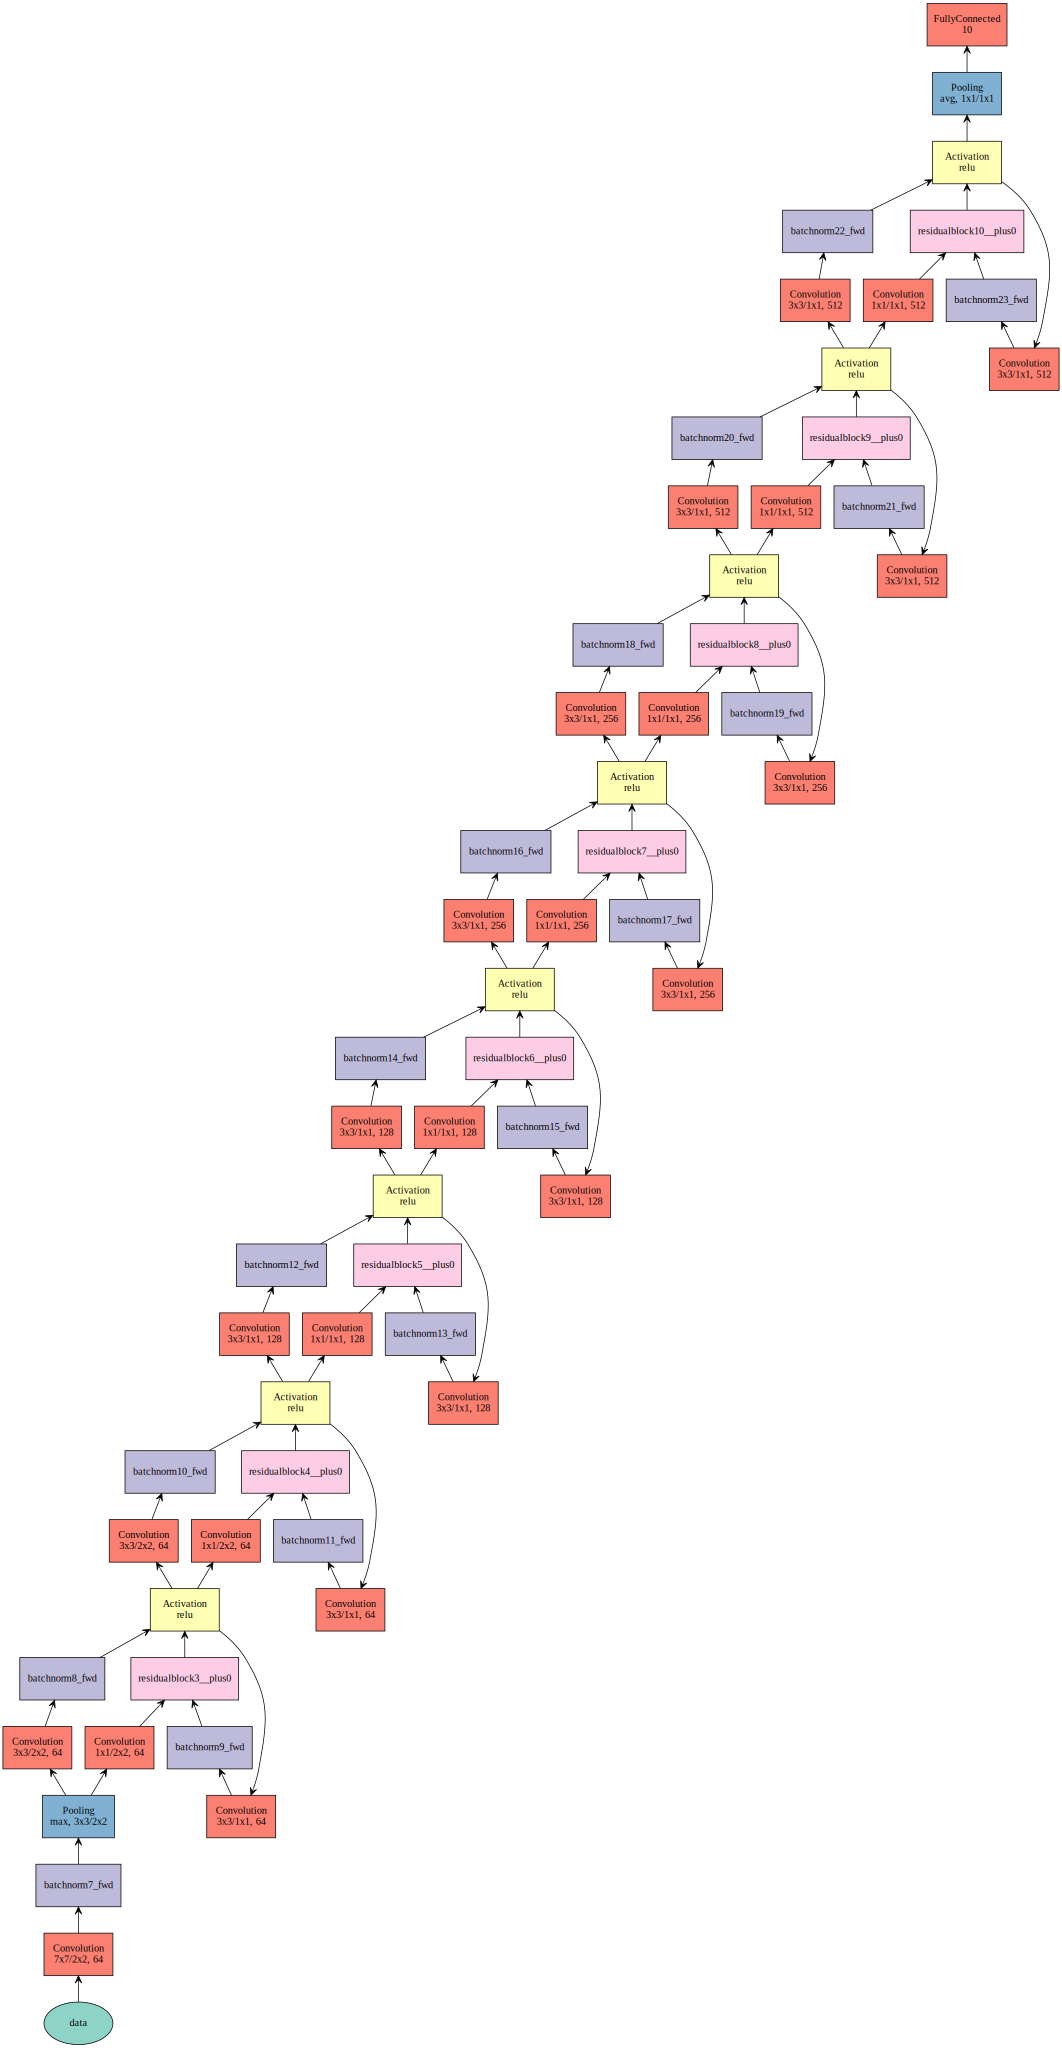

In [19]:
plot = mx.viz.plot_network(model(mx.sym.var(name = 'data')), node_attrs={"fixedsize":"false"})
plot

In [0]:
model.hybridize()

## __Defining our objective loss and optimizer__

In [0]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

## __Training the model__

In [21]:
epochs = 10
batches = len(train_data)
acc = mx.metric.Accuracy()

for epoch in range(epochs):
    acc.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        acc.update(labels, outputs)
    
    print(f'Epoch: {epoch + 1} | Loss: {cum_loss.asscalar()/batches:.5f} | Training Accuracy: {acc.get()[1]:.5f}')

Epoch: 1 | Loss: 1.50939 | Training Accuracy: 0.45300
Epoch: 2 | Loss: 1.14545 | Training Accuracy: 0.59538
Epoch: 3 | Loss: 0.96951 | Training Accuracy: 0.65952
Epoch: 4 | Loss: 0.85824 | Training Accuracy: 0.70138
Epoch: 5 | Loss: 0.77349 | Training Accuracy: 0.73142
Epoch: 6 | Loss: 0.69979 | Training Accuracy: 0.75850
Epoch: 7 | Loss: 0.63920 | Training Accuracy: 0.77964
Epoch: 8 | Loss: 0.57736 | Training Accuracy: 0.80166
Epoch: 9 | Loss: 0.52713 | Training Accuracy: 0.81784
Epoch: 10 | Loss: 0.48115 | Training Accuracy: 0.83326


## __Testing the model__

In [22]:
acc.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    acc.update(labels, outputs)
acc.get()

('accuracy', 0.84116)